<a href="https://colab.research.google.com/github/ChristopherLiew/Building-A-Generalisable-Red-Wine-Quality-Classifier/blob/master/L1_%26_L2_Regularsation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Lasso (L1) & Ridge (L2) Regression</h1>


In [0]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot') # optional: for ggplot-like style
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV

In [12]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")

<h2>Data Preprocessing</h2>

In [14]:
# Target Variable
wine_df["good_quality"] = wine_df["quality"] >= 7
target = wine_df.loc[:, 'good_quality']
target = target.astype(int)  # 1 = good quality & 0 = other quality
target

# Feature Scaling 
from sklearn.preprocessing import RobustScaler
robust = RobustScaler(quantile_range=(0.25, 0.75))  
norm_df = wine_df.drop(columns=['quality', 'good_quality']).copy()
norm_df = pd.DataFrame(robust.fit_transform(norm_df), columns=norm_df.columns)

# Interaction Terms
norm_df['total acidity'] = norm_df['fixed acidity'] + norm_df['volatile acidity']
norm_df['pH_sulphate'] = norm_df['pH'] * norm_df['sulphates']

# Standardisation
col_names = norm_df.columns

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(norm_df)
scaled_df = pd.DataFrame(scaled_df, columns=col_names)

# Feature Selection vis VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_VIF(x):
    threshold = 5
    selected_var = pd.DataFrame()
    ncol = len(x.columns)
    vif = [variance_inflation_factor(x.values, i) for i in range(ncol)]
    for i in range(1, ncol):
        print("Iteration Number: ", i)
        print(vif)
        a = np.argmax(vif)
        print("Max. VIF is for variable number: ", a)
        if (vif[a] <= threshold):
            break
        if (i == 1):
            selected_var = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(selected_var.values, j) for j in range(selected_var.shape[1])]
        elif (i > 1):
            selected_var = selected_var.drop(selected_var.columns[a], axis=1)
            vif = [variance_inflation_factor(selected_var.values, j) for j in range(selected_var.shape[1])]
    return (selected_var)

selected_features = calculate_VIF(scaled_df)# Target Variable
selected_features_df = pd.DataFrame(selected_features.columns.values.tolist(), columns=["Selected Features"])
selected_features_df

Iteration Number:  1
[inf, inf, 3.1281290523158005, 1.7050146798119519, 1.5807565886372779, 1.972946740703337, 2.1911132550421315, 6.401378378562339, 3.418075290279779, 1.9294858502023096, 3.0471893581144673, inf, 1.8901278619471857]
Max. VIF is for variable number:  0
Iteration Number:  2
[4.067156019844889, 3.128129052315802, 1.7050146798119514, 1.5807565886372779, 1.9729467407033374, 2.1911132550421315, 6.401378378562339, 3.4180752902797775, 1.9294858502023091, 3.0471893581144673, 7.777465491607318, 1.8901278619471857]
Max. VIF is for variable number:  10
Iteration Number:  3
[1.827863418227597, 2.780556884999453, 1.387967806076385, 1.4970809929155795, 1.9486290731175169, 2.0729809127030068, 2.4729891934935195, 1.712529070657663, 1.8920293970498296, 2.1483565167017966, 1.8896051346682705]
Max. VIF is for variable number:  1


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Selected Features
0,volatile acidity
1,citric acid
2,residual sugar
3,chlorides
4,free sulfur dioxide
5,total sulfur dioxide
6,density
7,pH
8,sulphates
9,alcohol


In [15]:
# Unscaled Red Wine Dataset
new_df = wine_df.copy()
target = wine_df.good_quality.copy() 
new_df.drop(columns=["quality", "good_quality"], inplace=True)

# Create interaction terms
new_df["total_acidity"] = new_df["fixed acidity"] + new_df["volatile acidity"]
new_df['pH_sulphate'] = new_df['pH'] * new_df['sulphates']
new_df = new_df.loc[:, selected_features.columns.values.tolist()]
new_df.head()

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pH_sulphate
0,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1.9656
1,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2.1760
2,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2.1190
3,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.8328
4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1.9656


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.25,random_state=0)

from sklearn.preprocessing import RobustScaler
robust = RobustScaler(quantile_range=(0.25, 0.75))  
X_train_scaled = pd.DataFrame(robust.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(robust.fit_transform(X_test), columns=X_test.columns)

<h2> Ridge Regression</h2>

<h3>Finding the Optimal Regularisation Parameter</h3>

In [17]:
# Finding optimal alpha (penalty parameter) via Cross Validation
alphas = 10**np.linspace(10,-2,100)*0.5 
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train_scaled, y_train)
ridgecv.alpha_

0.005

<h3>Training the Ridge Regression model</h3>

In [0]:
rr = Ridge(alpha = ridgecv.alpha_, normalize = True)
rr.fit(X_train_scaled, y_train)
y_prob = rr.predict(X_test_scaled) 
y_pred = np.where(y_prob > 0, 1, 0) 

<h3>Evaluating Ridge</h3>

In [19]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
False,0.979167,0.529577,0.687386,355.0000
True,0.197115,0.911111,0.324111,45.0000
accuracy,0.572500,0.572500,0.572500,0.5725
macro avg,0.588141,0.720344,0.505748,400.0000
weighted avg,0.891186,0.572500,0.646517,400.0000


<h3>ROC & AUC</h3>

Text(0.5, 0, 'False Positive Rate')

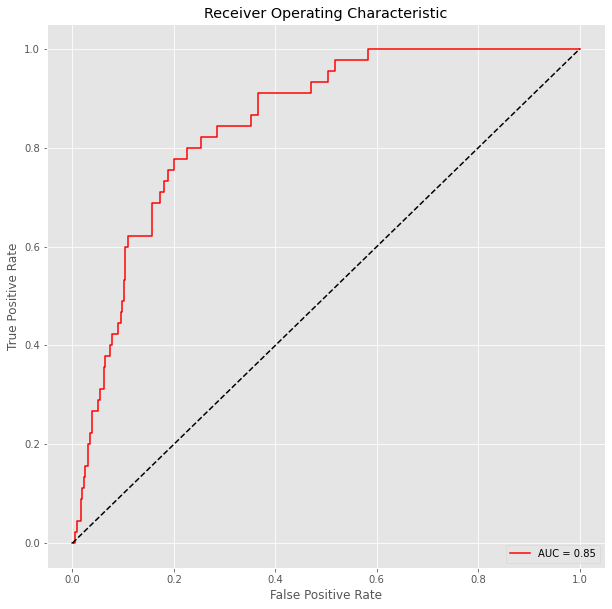

In [20]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc_ridge = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc_ridge)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--', color='black')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

<h2> LASSO Regression</h2>


<h3>Training the LASSO Regression Model</h3>

In [0]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_scaled), y_train)
    coefs.append(lasso.coef_)

In [0]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train_scaled, y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_scaled, y_train)
l_prob = lasso.predict(X_test_scaled) 
l_pred = np.where(l_prob > 0, 1, 0)  

<h3>Evaluating LASSO Regression</h3>

In [23]:
report = classification_report(y_test, l_pred, output_dict = True)
report_df_lasso = pd.DataFrame(report).transpose()
report_df_lasso

,precision,recall,f1-score,support
False,0.979487,0.538028,0.694545,355.00
True,0.200000,0.911111,0.328000,45.00
accuracy,0.580000,0.580000,0.580000,0.58
macro avg,0.589744,0.724570,0.511273,400.00
weighted avg,0.891795,0.580000,0.653309,400.00


In [24]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, l_prob)
roc_auc_lasso = auc(false_positive_rate, true_positive_rate)
roc_auc_lasso

0.8503286384976525

Text(0.5, 0, 'False Positive Rate')

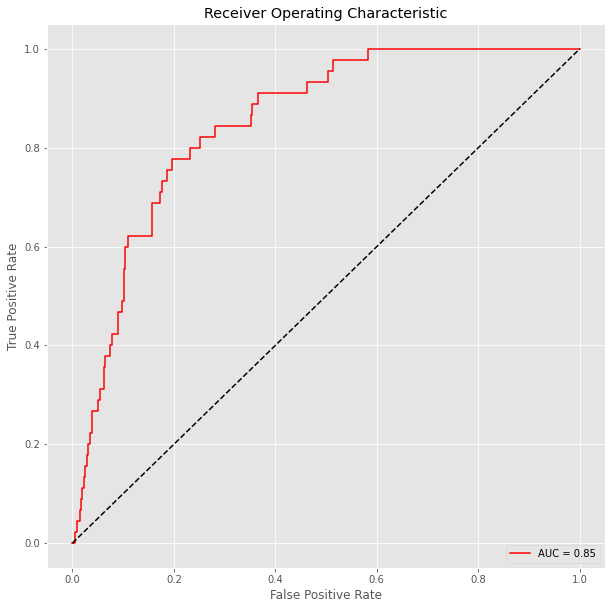

In [25]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc_lasso)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--', color='black')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')